# Laub-Loomis


## Model description

The Laub-Loomis model is presented in [^LL98] for studying a class of enzymatic activities.
The dynamics can be defined by the following ODE with 7 variables.

In [1]:
using ReachabilityAnalysis, Plots

@taylorize function laubloomis!(dx, x, params, t)
    dx[1] = 1.4*x[3] - 0.9*x[1]
    dx[2] = 2.5*x[5] - 1.5*x[2]
    dx[3] = 0.6*x[7] - 0.8*(x[2]*x[3])
    dx[4] = 2 - 1.3*(x[3]*x[4])
    dx[5] = 0.7*x[1] - (x[4]*x[5])
    dx[6] = 0.3*x[1] - 3.1*x[6]
    dx[7] = 1.8*x[6] - 1.6*(x[2]*x[7])
    return dx
end

The system is asymptotically stable and the equilibrium is the origin.

## Specifications

The specification for the analysis is given next.
The initial sets are defined according to the ones used in [^TD13].
They are boxes centered at
``x_1(0) = 1.2``, ``x_2(0) = 1.05``, ``x_3(0) = 1.5``, ``x_4(0) = 2.4``,
``x_5(0) = 1``, ``x_6(0) = 0.1``, ``x_7 (0) = 0.45``.
The range of the box in the i-th dimension is defined by the interval ``[x_i(0) − W, x_i(0) + W]``.
The width ``W`` of the initial set is vital to the difficulty of the reachability analysis job.
The larger the initial set the harder the reachability analysis.

In [2]:
function laubloomis(; W=0.01)
    # initial states
    X0c = [1.2, 1.05, 1.5, 2.4, 1.0, 0.1, 0.45]
    X0 = Hyperrectangle(X0c, fill(W, 7))

    # initial-value problem
    prob = @ivp(x' = laubloomis!(x), dim: 7, x(0) ∈ X0)

    return prob
end

laubloomis (generic function with 1 method)

We consider ``W = 0.01``, ``W = 0.05``, and ``W = 0.1``. The specification for each
scenario is the following:

- ``W = 0.01`` and ``W = 0.05``: the unsafe region is defined by ``x_4 ≥ 4.5
- ``W = 0.1``: the unsafe set is defined by ``x_4 ≥ 5``.

The time horizon for all cases is [0, 20].

## Results

The final widths of ``x_4`` along with the computation times are provided for all three cases. A
figure is provided in the ``(t, x_4)`` axes, with ``t ∈ [0, 20]``, ``x_4 ∈ [1.5, 5]``,
where the three plots are overlaid.

Since the safety condition is only related to the variable ``x_4``, we present the
plots of projections of the overapproximations in the ``t - x_4`` plane such that
``t`` is the time variable.

### Case 1: Smaller initial states

In this case we consider thet the width of the initial states is ``W = 0.01``.

In [3]:
prob = laubloomis(W=0.01)
alg = TMJets(abstol=1e-11, orderT=7, orderQ=1, adaptive=true);

sol_1 = solve(prob, T=20.0, alg=alg);

sol_1z = overapproximate(sol_1, Zonotope);

Verifying that the specifications hold:

In [4]:
# canonical direction along x₄
const e4 = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0];

ρ(e4, sol_1z)

4.347181052143644

In [5]:
ρ(e4, sol_1z) < 4.5

true

To compute the width of the final box width of the final box we use support functions:

In [6]:
@show ρ(e4, sol_1z[end]) + ρ(-e4, sol_1z[end])

ρ(e4, sol_1z[end]) + ρ(-e4, sol_1z[end]) = 0.004238950465202507


0.004238950465202507

### Case 2: Intermediate initial states

In this case we consider the the width of the initial states is ``W = 0.05``.

In [7]:
prob = laubloomis(W=0.05)
alg = TMJets(abstol=1e-12, orderT=7, orderQ=1, adaptive=false);

sol_2 = solve(prob, T=20.0, alg=alg)
sol_2z = overapproximate(sol_2, Zonotope);

Verifying that the specification holds:

In [8]:
ρ(e4, sol_2z)

4.462157651009224

In [9]:
ρ(e4, sol_2z) < 4.5

# width of final box
@show ρ(e4, sol_2z[end]) + ρ(-e4, sol_2z[end])

ρ(e4, sol_2z[end]) + ρ(-e4, sol_2z[end]) = 0.017468964603667203


0.017468964603667203

### Case 3: Larger initial states

In this case we consider that the width of the initial states is ``W = 0.1``.

In [10]:
prob = laubloomis(W=0.1)
alg = TMJets(abstol=1e-12, orderT=7, orderQ=1, adaptive=false);

sol_3 = solve(prob, T=20.0, alg=alg)
sol_3z = overapproximate(sol_3, Zonotope);

Verifying that the specification holds:

In [11]:
ρ(e4, sol_3z)

4.607152446545931

ρ(e4, sol_3z[end]) + ρ(-e4, sol_3z[end]) = 0.03370610732515722


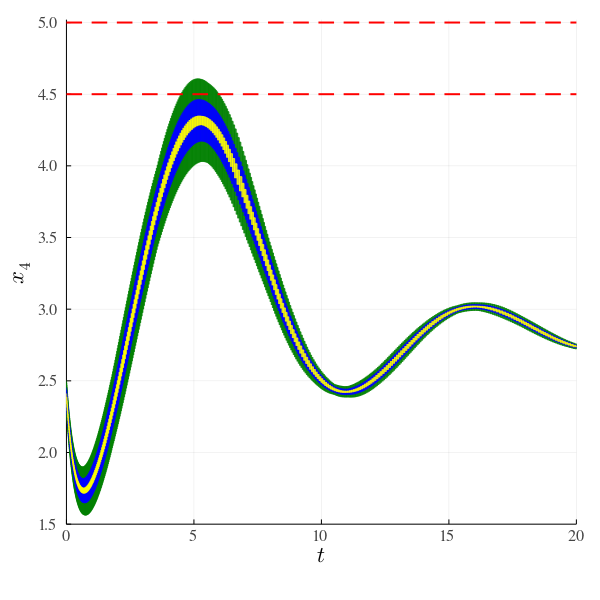

In [12]:
ρ(e4, sol_3z) < 5.0

# width of final box
@show ρ(e4, sol_3z[end]) + ρ(-e4, sol_3z[end])

using Plots, Plots.PlotMeasures, LaTeXStrings

fig = plot()
plot!(fig, sol_3z, vars=(0, 4), linecolor="green", color=:green, alpha=0.8)
plot!(fig, sol_2z, vars=(0, 4), linecolor="blue",  color=:blue, alpha=0.8)
plot!(fig, sol_1z, vars=(0, 4), linecolor="yellow", color=:yellow, alpha=0.8,
      tickfont=font(10, "Times"), guidefontsize=15,
      xlab=L"t",
      ylab=L"x_4",
      xtick=[0., 5., 10., 15., 20.], ytick=[1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5.],
      xlims=(0., 20.), ylims=(1.5, 5.02),
      bottom_margin=6mm, left_margin=2mm, right_margin=4mm, top_margin=3mm,
      size=(600, 600))

plot!(fig, x->x, x->4.5, 0., 20., line=2, color="red", linestyle=:dash, legend=nothing)
plot!(fig, x->x, x->5., 0., 20., line=2, color="red", linestyle=:dash, legend=nothing)

## References

[^LL98]: M. T. Laub and W. F. Loomis. *A molecular network that produces spontaneous oscillations in excitable cells of dictyostelium.* Molecular Biology of the Cell, 9:3521–3532, 1998.

[^TD13]: R. Testylier and T. Dang. *NLTOOLBOX: A library for reachability computation of nonlinear dynamical systems.* In Proc. of ATVA’13, volume 8172 of LNCS, pages 469–473. Springer, 2013.